In [5]:
import numpy as np
from modules.utils import plot_disp_curves
from evodcinv import EarthModel, Layer, Curve
from disba import PhaseDispersion, GroupDispersion
from collections import namedtuple
import matplotlib.pylab as plt

In [8]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from disba import Ellipticity, depthplot, resample, surf96

from disba import Ellipticity, depthplot, resample, surf96
from disba._common import ifunc
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from joblib import Parallel, delayed


cmap = cm.get_cmap('gnuplot2')
cmap = ListedColormap(cmap(np.linspace(0.1, 0.9, 256)))

cmap = cm.get_cmap('gray')
cmap = ListedColormap(cmap(np.linspace(0, 0.9, 256)))

/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_55447/1056908157.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gnuplot2')
/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_55447/1056908157.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gray')


In [40]:
def plot_predicted_curve(inv_result, period, mode, wave, type, show="best", stride=1, percent=10, 
                         plot_args=None, ax=None):
    
    if type not in {"phase", "group", "ellipticity"}:
        raise ValueError()
    
    # Default parameters
    n_jobs = -1
    dc = 0.001
    dt = 0.01
    itype = {"phase": 0, "group": 1}
    units = {"frequency": "Hz", "period": "s"}
    
    # Model dispersion curves
    def get_y(thickness, velocity_p, velocity_s, density):
        c = surf96(period, thickness, velocity_p, velocity_s, density, mode, 
                   itype[type], ifunc["dunkin"][wave], dc, dt)
        idx = c > 0.0
        return c[idx]
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"type": "line", "xaxis": "period", "yaxis": "velocity", "cmap": "Oranges_r"}
    _plot_args.update(plot_args)

    plot_type = _plot_args.pop("type")
    xaxis = _plot_args.pop("xaxis")
    yaxis = _plot_args.pop("yaxis")
    cmap = _plot_args.pop("cmap")
    
    plot_type = plot_type if plot_type != "line" else "plot"
    plot = getattr(plt if ax is None else ax, plot_type)
    x = 1.0 / period if xaxis == "frequency" else period
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot curves from %d models.' %misfits.shape[0])

        # Make colormap
        norm = Normalize(misfits.min(), misfits.max())
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Generate and plot curves
        curves = Parallel(n_jobs=n_jobs)(delayed(get_y)(*model.T) for model in models)
        for curve, misfit in zip(curves, misfits):
            y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
            plot(x[: len(y)], y, color=smap.to_rgba(misfit), **_plot_args)

    elif show == "best":
        curve = get_y(*inv_result.model.T)
        y = y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
        plot(x[: len(y)], y, **_plot_args)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()

    xlabel = f"{xaxis.capitalize()} [{units[xaxis]}]"
    ylabel = f"{type.capitalize()} "
    ylabel += f"{yaxis} [m/s]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)

    # Disable exponential tick labels
    gca.xaxis.set_major_formatter(ScalarFormatter())
    gca.xaxis.set_minor_formatter(ScalarFormatter())
    
    
def plot_model(inv_result, parameter, show="best", stride=1, percent=10, zmax=None, 
               plot_args=None, ax=None, cmap_on=False, cmap_args=None, cmap_range=None):
    
    parameters = {
            "velocity_p": 1,
            "velocity_s": 2,
            "density": 3,
            "vp": 1,
            "vs": 2,
            "rho": 3,
    }
    
    if parameter not in parameters:
        raise ValueError()
    i_param = parameters[parameter]
        
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"cmap": "gist_ncar", "color": "black", "linewidth": 2}
    _plot_args.update(plot_args)

    cmap = _plot_args.pop("cmap")
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot %d models.' %misfits.shape[0])

        # Make colormap
        if cmap_range is None:
            norm = Normalize(misfits.min(), misfits.max())
        else:
            norm = Normalize(cmap_range[0], cmap_range[1])
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Plot models
        for model, misfit in zip(models, misfits):
            tmp = {k: v for k, v in _plot_args.items()}
            tmp["color"] = smap.to_rgba(misfit)
            depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=tmp, ax=ax)

    elif show == "best":
        model = inv_result.model
        depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    elif show == "mean":
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[:n_select+1]
        print('Plot mean of %d models.' %models.shape[0])
        print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))
        
        # Plot mean model
        model_mean = np.squeeze(np.mean(models, axis=0))
        depthplot(model_mean[:, 0]*1e3, model_mean[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()
    labels = {
        "velocity_p": "P-wave velocity [m/s]",
        "velocity_s": "S-wave velocity [m/s]",
        "density": "Density [$kg/m^3$]",
        "vp": "$V_p$ [m/s]",
        "vs": "$V_s$ [m/s]",
        "rho": "$\\rho$ [$kg/m^3$]",
    }
    xlabel = labels[parameter]
    ylabel = "Depth [m]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)
    
    # # Colorbar
    # if cmap_on:
    #     cmap_args = cmap_args if cmap_args is not None else {}
    #     _cmap_args = {"orientation": "vertical", "label": "Log Misfit", "location": "right"}
    #     _cmap_args.update(cmap_args)
    #     plt.colorbar(smap, **_cmap_args)
        
        
def plot_model_range(model, plot_args=None, ax=None):
    
    d1 = np.array([])
    vs1 = np.array([])
    d2 = np.array([])
    vs2 = np.array([])
    
    for layer in model.layers:
        d1 = np.append(d1, layer.thickness[1])
        vs1 = np.append(vs1, layer.velocity_s[0])
        d2 = np.append(d2, layer.thickness[0])
        vs2 = np.append(vs2, layer.velocity_s[1])
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"color": "black", "linewidth": 2}
    _plot_args.update(plot_args)
    
    d2[-1] = np.sum(d1) - np.sum(d2[:-1])
    depthplot(d1*1e3, vs1*1e3, None, plot_args=_plot_args, ax=ax)
    depthplot(d2*1e3, vs2*1e3, None, plot_args=_plot_args, ax=ax)
    

def model_param_range(inv_result, percent=30, stride=None, plot_nu=False):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.xs[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    if stride is None:
        stride = int(n_select // 4)
    models = models[n_select::-stride]
    n_model = models.shape[0]
    print('Record %d models.' %n_model)
    
    # Model parameters
    n_layer = int((len(models[0])+1) // 3)
    h = np.percentile(models[:, :n_layer-1], [0,25,50,75,100], axis=0)
    vs = np.percentile(models[:, n_layer-1:2*n_layer-1], [0,25,50,75,100], axis=0)
    nu = np.percentile(models[:, 2*n_layer-1:], [0,25,50,75,100], axis=0)
    
    # Print 0, 25, 50, 75, 100 percentiles
    for i in range(n_layer):
        print('Layer %d' %i)
        if i < n_layer - 1:
            print('Thickness [km]: %.4f, %.4f, %.4f, %.4f %.4f' %(h[0,i], h[1,i], h[2,i], h[3,i], h[-1,i]))
        print('Vs [km/s]: %.4f, %.4f, %.4f, %.4f %.4f' %(vs[0,i], vs[1,i], vs[2,i], vs[3,i], vs[-1,i]))
        print('Nu: %.4f, %.4f, %.4f, %.4f %.4f' %(nu[0,i], nu[1,i], nu[2,i], nu[3,i], nu[-1,i]))
        print()

    if plot_nu:
        nu = models[n_select::-1, 2*n_layer-1:]
        for i in range(n_layer):
            plt.figure(figsize=(8,8))
            plt.hist(nu[:, i])
            plt.grid()
            plt.show()
        

def get_mean_model(inv_result, percent=30):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.models[idx]
    misfits = inv_result.misfits[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    models = models[:n_select+1]
    print('Get mean of %d models.' %models.shape[0])
    print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))

    # Return mean model
    model_mean = np.squeeze(np.mean(models, axis=0))
    return model_mean


def plot_curve(curve, xlabel='freq', color='k', scale=1e3, alpha=1.0):
    
    if xlabel == 'freq':
        if curve.uncertainties is None:
            plt.scatter(1/curve.period, curve.data*scale, color=color, alpha=alpha)
        else:
            plt.errorbar(1/curve.period, curve.data*scale, yerr=curve.uncertainties*scale, fmt='o', color=color, alpha=alpha)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Velocity [m/s]')
        
    elif xlabel == 'period':
        if curve.uncertainties is None:
            plt.scatter(curve.period, curve.data*scale, color=color)
        else:
            plt.errorbar(curve.period, curve.data*scale, yerr=curve.uncertainties*scale, fmt='o', color=color)
        plt.xlabel('Period [s]')
        plt.ylabel('Velocity [m/s]')

# Different weights

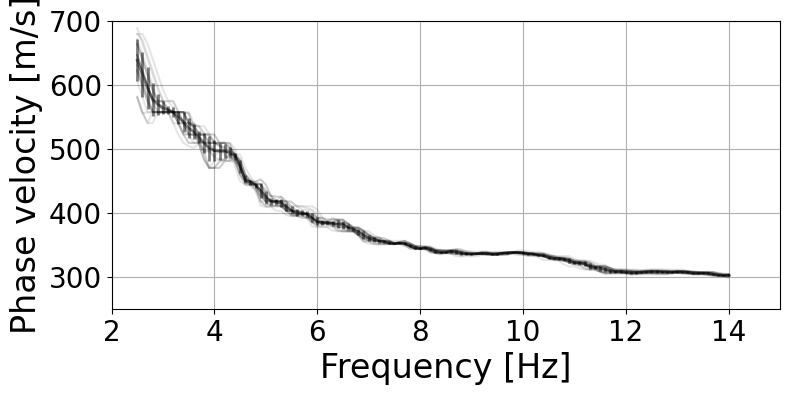

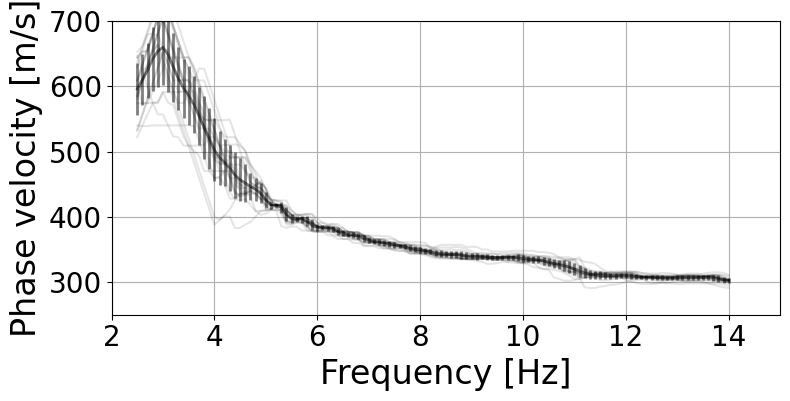

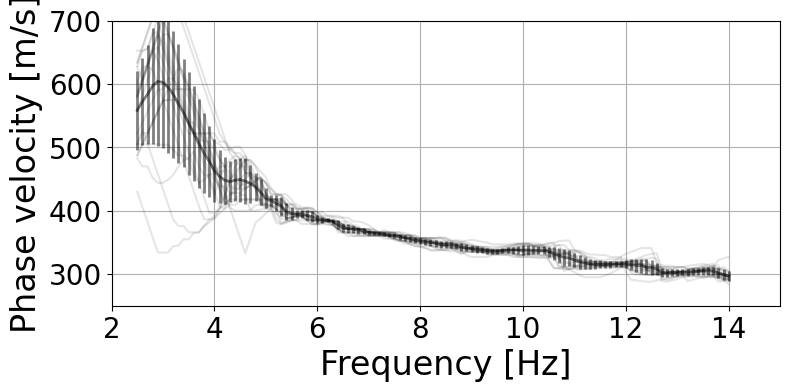

In [10]:
_x0 = 700
file_name = f'data/{_x0}_weights.npz'
data_weights = np.load(file_name)

vel_heavy_mean, vel_heavy_range = plot_disp_curves(data_weights['freqs'], data_weights['vels_heavy'])
vel_mid_mean, vel_mid_range = plot_disp_curves(data_weights['freqs'], data_weights['vels_mid'])
vel_light_mean, vel_light_range = plot_disp_curves(data_weights['freqs'], data_weights['vels_light'])

## Obtain dispersion curves

In [11]:
periods = np.array(1/data_weights['freqs'])[::-1]
disp_curves_heavy = [Curve(periods,vel_heavy_mean[::-1]/1000,0,'rayleigh','phase',uncertainties=vel_heavy_range[::-1]/1000)]
disp_curves_mid = [Curve(periods,vel_mid_mean[::-1]/1000,0,'rayleigh','phase',uncertainties=vel_mid_range[::-1]/1000)]
disp_curves_light = [Curve(periods,vel_light_mean[::-1]/1000,0,'rayleigh','phase',uncertainties=vel_light_range[::-1]/1000)]

## Build earth model

In [12]:
model = EarthModel()

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
model.add(Layer([0.001, 0.01], [0.2, 0.5]))
model.add(Layer([0.001, 0.01], [0.2, 0.5]))
model.add(Layer([0.001, 0.01], [0.2, 0.5]))
model.add(Layer([0.005, 0.02], [0.2, 0.5]))
model.add(Layer([0.005, 0.02], [0.2, 0.5]))
model.add(Layer([0.005, 0.02], [0.2, 0.5]))
model.add(Layer([0.005, 0.02], [0.3, 0.6]))
model.add(Layer([0.005, 0.02], [0.3, 0.6]))
model.add(Layer([0.005, 0.02], [0.3, 0.6]))
model.add(Layer([0.005, 0.04], [0.4, 0.8]))
model.add(Layer([0.005, 0.04], [0.4, 0.8]))
model.add(Layer([0.005, 0.04], [0.4, 0.8]))

# Configure model
model.configure(
    optimizer="cpso",  # Evolutionary algorithm
    misfit="rmse",  # Misfit function type
    optimizer_args={
        "popsize": 10,  # Population size
        "maxiter": 5000,  # Number of iterations
        "workers": -1,  # Number of cores
        "seed": 0,
    },
)

model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    0.0010    0.0100    0.2000    0.5000    0.2000    0.4000
    0.0010    0.0100    0.2000    0.5000    0.2000    0.4000
    0.0010    0.0100    0.2000    0.5000    0.2000    0.4000
    0.0050    0.0200    0.2000    0.5000    0.2000    0.4000
    0.0050    0.0200    0.2000    0.5000    0.2000    0.4000
    0.0050    0.0200    0.2000    0.5000    0.2000    0.4000
    0.0050    0.0200    0.3000    0.6000    0.2000    0.4000
    0.0050    0.0200    0.3000    0.6000    0.2000    0.4000
    0.0050    0.0200    0.3000    0.6000    0.2000    0.4000
    0.0050    0.0400    0.4000    0.8000    0.2000    0.4000
    0.0050    0.0400    0.4000    0.8000 

## Run inversion

In [13]:
res_heavy = model.invert(disp_curves_heavy, maxrun=1)
res_mid = model.invert(disp_curves_mid, maxrun=1)
res_light = model.invert(disp_curves_light, maxrun=1)

Run 1   |████████████████████| 100% [0:01:12 / 0:00:00] - Misfit: 0.5359
Run 1   |████████████████████| 100% [0:01:12 / 0:00:00] - Misfit: 0.1455
Run 1   |████████████████████| 100% [0:01:11 / 0:00:00] - Misfit: 0.1175


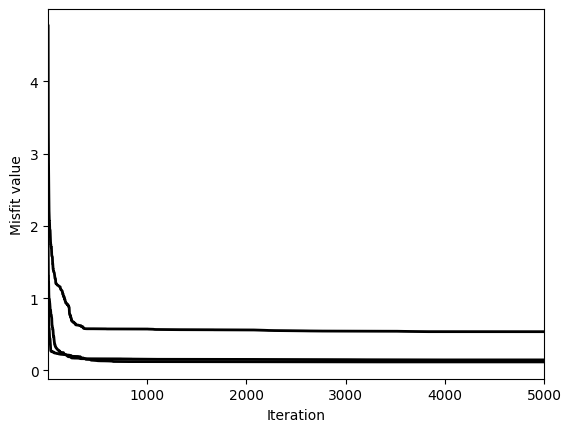

In [14]:
res_heavy.plot_misfit()
res_mid.plot_misfit()
res_light.plot_misfit()

## Plot results

Plot 500 models.
Plot mean of 15001 models.
Misfit range: 0.5359, 0.5419.


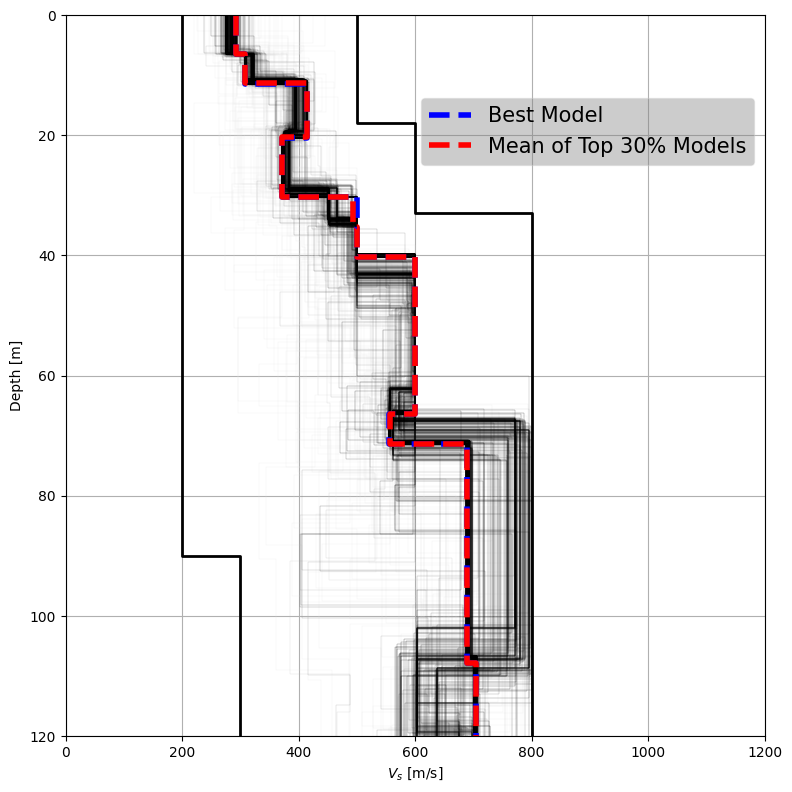

In [15]:
# Colormap: YlGnBu_r, winter
param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
plot_model(res_heavy, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res_heavy, param, show='best', plot_args={"color":"blue", "linewidth":4, "linestyle":"--"})
plot_model(res_heavy, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))


ax.set_ylim([120, 0])
ax.set_xlim([0, 1200])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)

Plot 500 models.
Plot mean of 15001 models.
Misfit range: 0.1455, 0.1457.


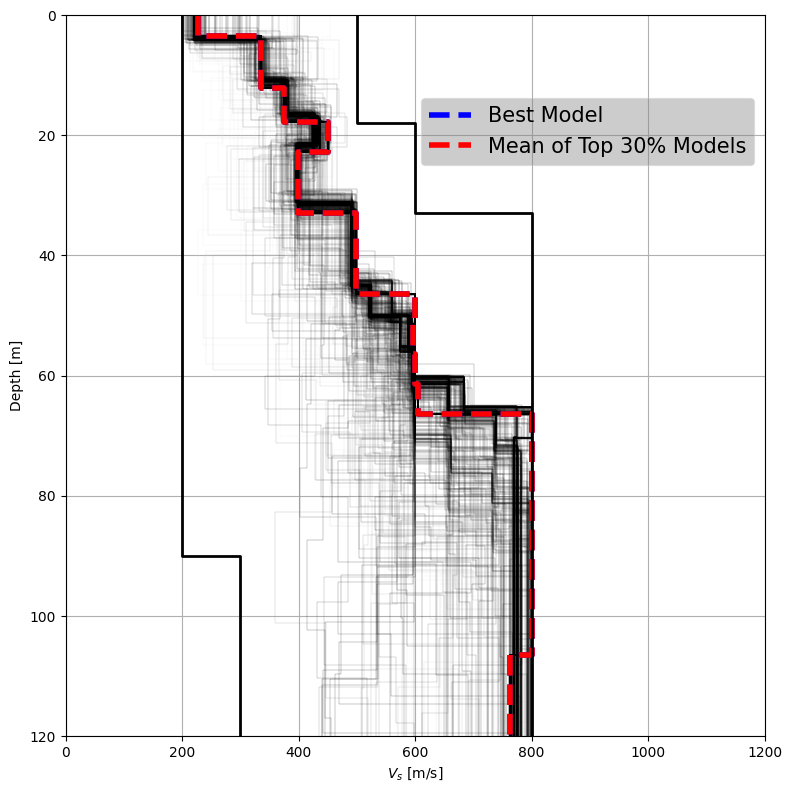

In [21]:
# Colormap: YlGnBu_r, winter
param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
plot_model(res_mid, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res_mid, param, show='best', plot_args={"color":"blue", "linewidth":4, "linestyle":"--"})
plot_model(res_mid, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))


ax.set_ylim([120, 0])
ax.set_xlim([0, 1200])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)

Plot 500 models.
Plot mean of 15001 models.
Misfit range: 0.1175, 0.1175.


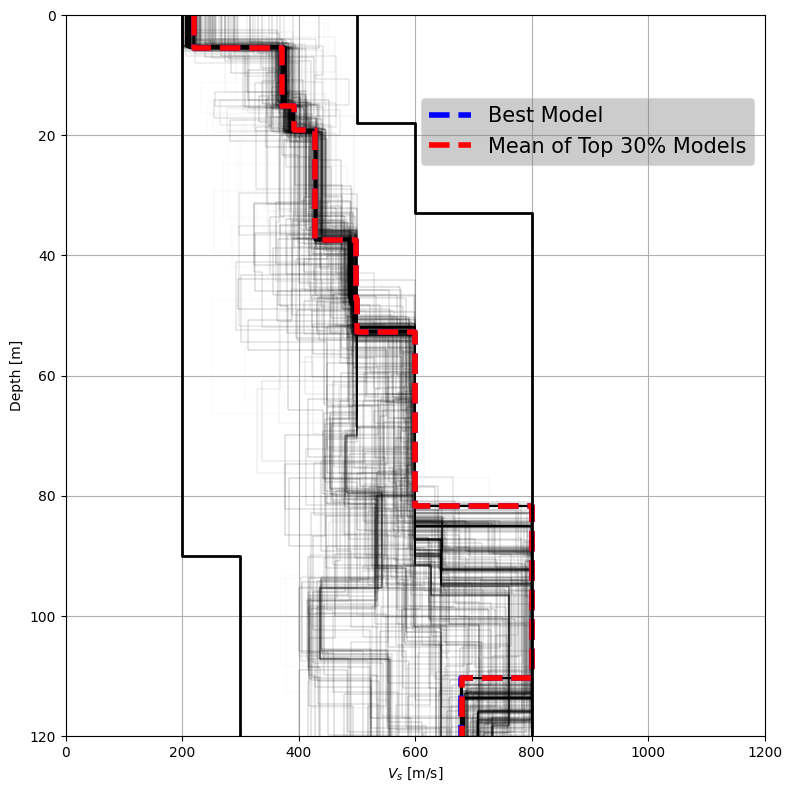

In [22]:
# Colormap: YlGnBu_r, winter
param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
plot_model(res_light, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res_light, param, show='best', plot_args={"color":"blue", "linewidth":4, "linestyle":"--"})
plot_model(res_light, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))


ax.set_ylim([120, 0])
ax.set_xlim([0, 1200])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)

# Different speeds

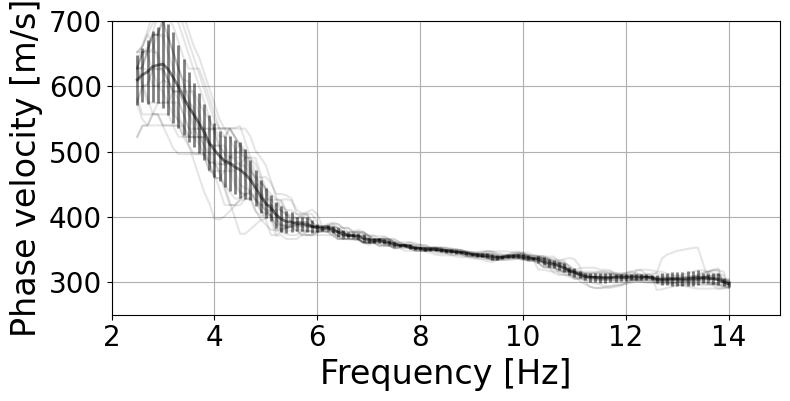

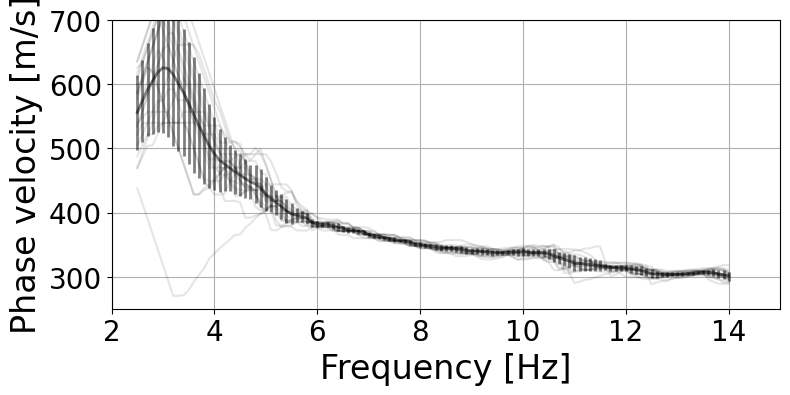

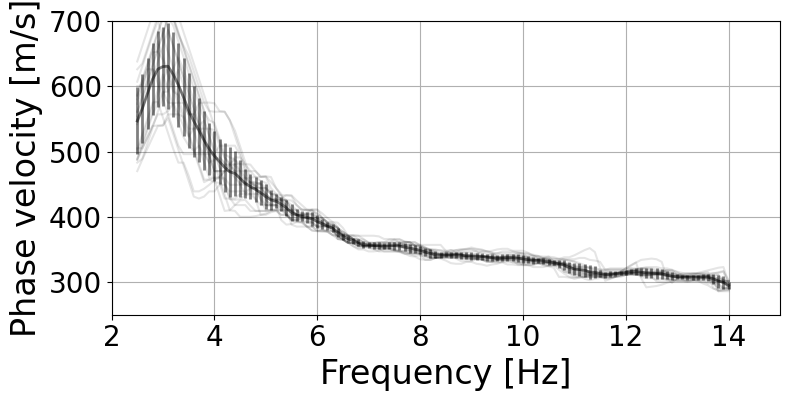

(array([546.85, 566.15, 589.1 , 610.9 , 626.3 , 630.15, 630.7 , 618.05,
        601.95, 583.35, 562.95, 546.35, 532.55, 517.05, 504.  , 493.25,
        484.65, 475.75, 468.9 , 466.45, 458.75, 451.35, 446.4 , 442.  ,
        437.1 , 430.85, 425.8 , 423.8 , 419.5 , 413.75, 406.75, 402.85,
        400.8 , 399.15, 396.85, 392.9 , 389.2 , 385.8 , 382.45, 376.2 ,
        370.2 , 366.4 , 363.5 , 360.15, 357.7 , 356.85, 356.15, 355.65,
        355.  , 355.55, 355.8 , 355.15, 353.75, 352.1 , 350.5 , 348.6 ,
        346.05, 343.85, 342.  , 341.55, 341.6 , 341.35, 341.45, 341.05,
        340.35, 340.05, 339.65, 339.1 , 337.85, 337.35, 336.7 , 337.15,
        337.65, 337.45, 336.65, 335.6 , 334.35, 333.35, 333.  , 332.1 ,
        331.3 , 329.55, 327.95, 326.  , 322.5 , 320.2 , 319.1 , 317.85,
        315.55, 314.85, 313.05, 311.55, 311.95, 312.55, 313.9 , 314.8 ,
        316.15, 316.55, 315.25, 314.  , 313.65, 312.95, 312.65, 310.6 ,
        309.05, 308.3 , 307.8 , 307.4 , 307.65, 307.75, 307.85, 

In [23]:
file_name = f'data/{_x0}_speeds.npz'
data_speeds = np.load(file_name)

plot_disp_curves(data_speeds['freqs'], data_speeds['vels_fast'])
plot_disp_curves(data_speeds['freqs'], data_speeds['vels_mid'])
plot_disp_curves(data_speeds['freqs'], data_speeds['vels_slow'])

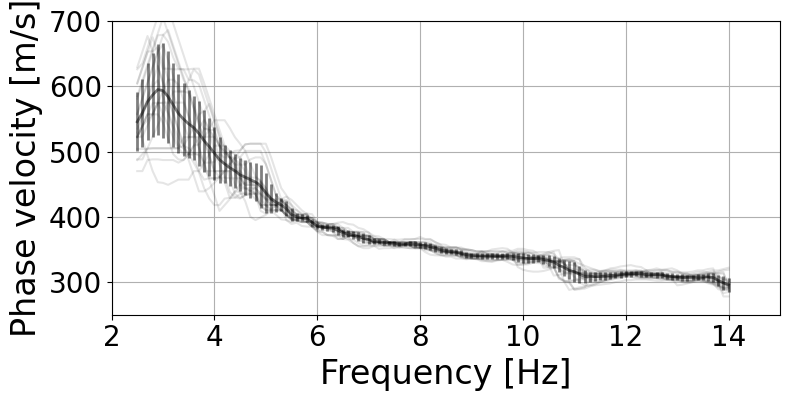

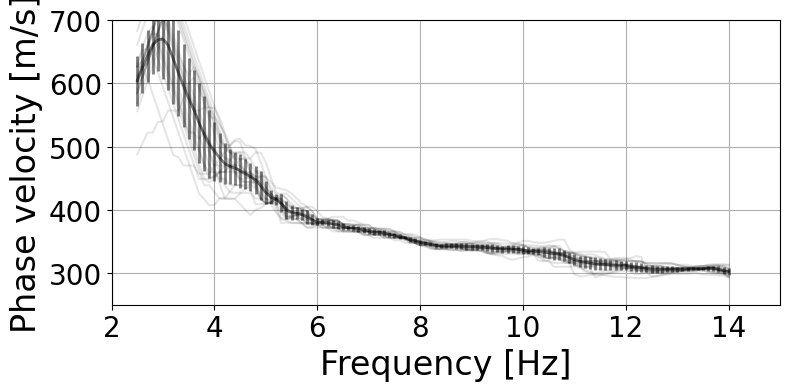

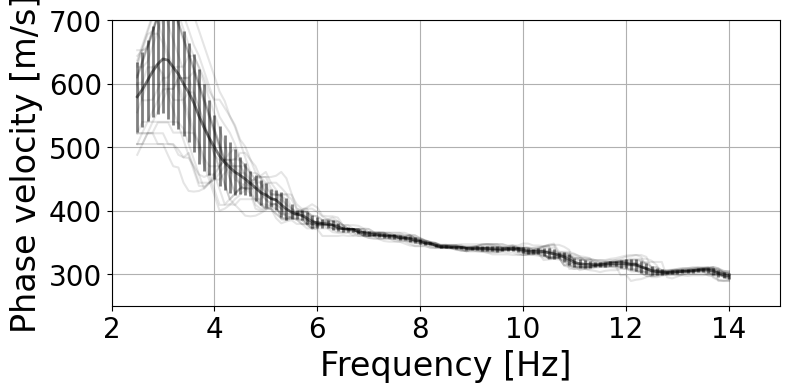

(array([579.6 , 591.1 , 605.3 , 619.4 , 631.3 , 639.2 , 637.3 , 626.05,
        615.45, 599.8 , 586.55, 569.8 , 549.  , 530.65, 514.7 , 500.2 ,
        486.2 , 476.1 , 467.85, 460.85, 455.55, 449.95, 442.95, 436.  ,
        428.85, 424.25, 419.45, 416.45, 409.3 , 402.5 , 397.9 , 394.2 ,
        392.75, 388.15, 382.3 , 381.15, 379.7 , 379.2 , 377.25, 374.35,
        371.3 , 370.4 , 369.45, 367.5 , 364.8 , 363.25, 362.3 , 361.5 ,
        360.75, 359.65, 359.2 , 357.7 , 356.7 , 355.7 , 353.35, 351.55,
        349.2 , 347.75, 345.45, 343.3 , 343.25, 342.75, 342.4 , 341.7 ,
        340.4 , 340.55, 340.75, 340.5 , 340.45, 340.  , 339.65, 339.6 ,
        339.75, 339.9 , 339.2 , 337.55, 336.2 , 335.75, 336.15, 335.3 ,
        333.25, 331.85, 329.6 , 326.9 , 322.95, 318.45, 316.55, 315.45,
        315.  , 314.65, 314.85, 315.4 , 316.25, 316.55, 316.1 , 316.45,
        314.95, 314.3 , 311.4 , 308.5 , 305.2 , 304.1 , 303.05, 302.15,
        302.85, 303.6 , 304.25, 304.7 , 305.35, 306.1 , 306.5 , 

In [24]:
file_name = f'data/{_x0}_sizes.npz'
data_sizes = np.load(file_name)

plot_disp_curves(data_sizes['freqs'], data_sizes['vels_large'])
plot_disp_curves(data_sizes['freqs'], data_sizes['vels_mid'])
plot_disp_curves(data_sizes['freqs'], data_sizes['vels_small'])

### Plot the dispersion curve from inverted model against the measured data

In [49]:
# Get the Best Results from Heavy Car (not used in below, just show how to obatin these data)
heavy_depth = res_heavy.model[0]
vp_depth = res_heavy.model[1]
vs_depth = res_heavy.model[2]
rho_depth = res_heavy.model[3]

### Plot dispersion curves from Heavy car

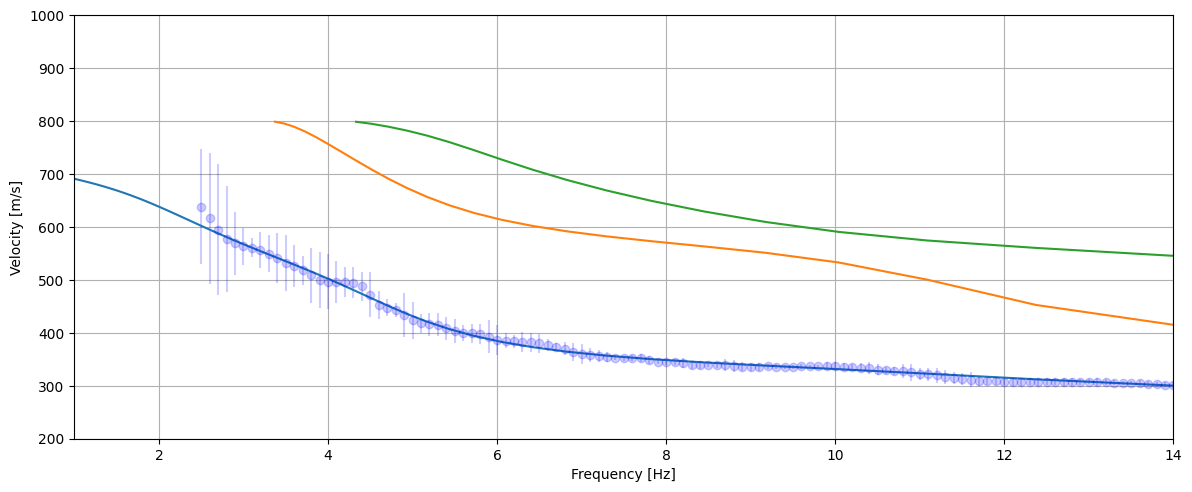

In [58]:
# show = 'percentage'
show = 'best'
percent = 30
stride = 20
f1 = 1.0  # from 1.0 Hz
f2 = 14.0 # to 14.0 Hz

fig, ax = plt.subplots(figsize=(12,5))

plot_curve(disp_curves_heavy[0], color='b', alpha=0.2)

plot_predicted_curve(res_heavy, np.linspace(1/f2, 1/f1, 100), 0, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_heavy, np.linspace(1/f2, 1/f1, 100), 1, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_heavy, np.linspace(1/f2, 1/f1, 100), 2, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})

ax.set_xlim([f1, f2])
ax.set_ylim([200, 1000])
ax.grid()    
ax.set_ylabel('Velocity [m/s]')
plt.tight_layout(pad=1.0)
plt.show()


### Plot dispersion curves from Mid car

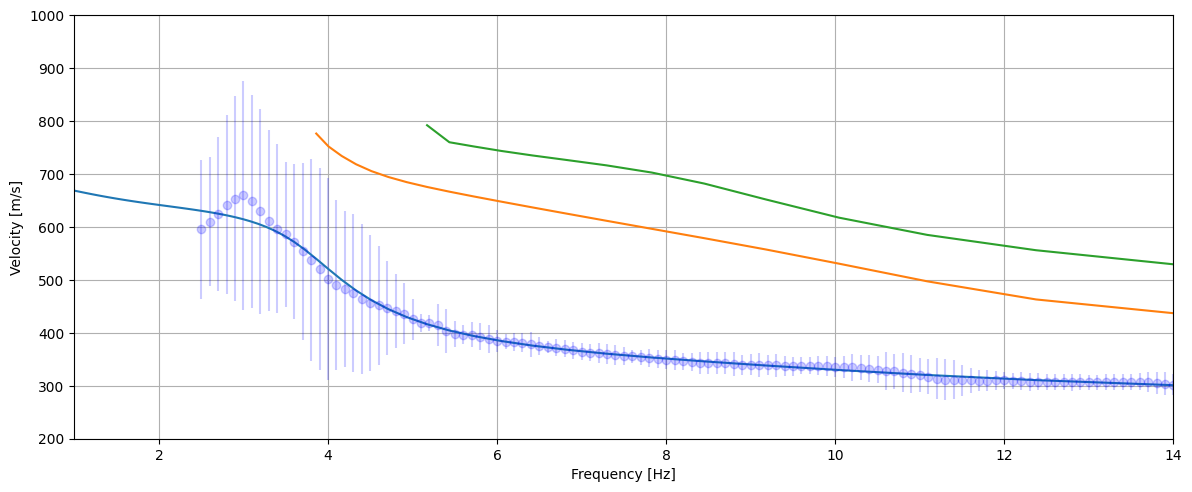

In [59]:
# show = 'percentage'
show = 'best'
percent = 30
stride = 20
f1 = 1.0  # from 1.0 Hz
f2 = 14.0 # to 14.0 Hz

fig, ax = plt.subplots(figsize=(12,5))

plot_curve(disp_curves_mid[0], color='b', alpha=0.2)
plot_predicted_curve(res_mid, np.linspace(1/f2, 1/f1, 100), 0, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_mid, np.linspace(1/f2, 1/f1, 100), 1, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_mid, np.linspace(1/f2, 1/f1, 100), 2, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})

ax.set_xlim([f1, f2])
ax.set_ylim([200, 1000])
ax.grid()    
ax.set_ylabel('Velocity [m/s]')
plt.tight_layout(pad=1.0)
plt.show()


### Plot dispersion curves from Light car

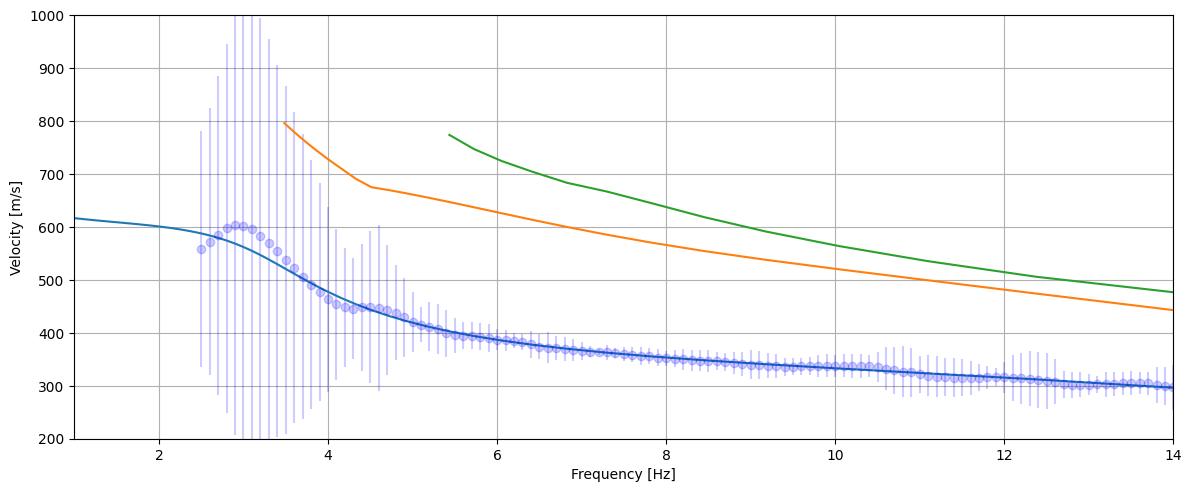

In [60]:
# show = 'percentage'
show = 'best'
percent = 30
stride = 20
f1 = 1.0  # from 1.0 Hz
f2 = 14.0 # to 14.0 Hz

fig, ax = plt.subplots(figsize=(12,5))

plot_curve(disp_curves_light[0], color='b', alpha=0.2)
plot_predicted_curve(res_light, np.linspace(1/f2, 1/f1, 100), 0, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_light, np.linspace(1/f2, 1/f1, 100), 1, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res_light, np.linspace(1/f2, 1/f1, 100), 2, 'rayleigh', 'phase', show=show, percent=percent, ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})

ax.set_xlim([f1, f2])
ax.set_ylim([200, 1000])
ax.grid()    
ax.set_ylabel('Velocity [m/s]')
plt.tight_layout(pad=1.0)
plt.show()
